In [1]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
    print(tok.text, "--->", tok.dep_)
    
# subject is  nsubj 
# object is   dobj

The ---> det
22 ---> nummod
- ---> punct
year ---> npadvmod
- ---> punct
old ---> nsubj
recently ---> advmod
won ---> ROOT
ATP ---> compound
Challenger ---> compound
tournament ---> dobj
. ---> punct


In [8]:
doc = nlp("Nagal won the first set.")

for tok in doc:
    print(tok.text, "--->", tok.dep_)
    

Nagal ---> nsubj
won ---> ROOT
the ---> det
first ---> amod
set ---> dobj
. ---> punct


# Build a knowldge Graph from Text Data 

In [11]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = en_core_web_sm.load()

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [23]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [17]:
print(candidate_sentences['sentence'].sample(5))

458                            these festivals have included both mainstream and independent films.
811     christopher nolan's black-and-white debut, following , was an overt homage to classic noir.
1522                                                             t. v. chandran and shaji n. karun.
1732                                                   de basanti starred the english alice patten.
1238                                                    although several films used 3d backgrounds.
Name: sentence, dtype: object


In [19]:
def get_entities(sent):
    
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
        #############################################################

    return [ent1.strip(), ent2.strip()]

In [21]:
get_entities("The 22-year-old recently won ATP Challenger tournament.")


['year  old', 'recently ATP Challenger tournament']

In [24]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
      entity_pairs.append(get_entities(i))

100%|█████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:21<00:00, 198.18it/s]


In [26]:
print(entity_pairs[10:20])

[['we', 'tests'], ['', 'international sales rights'], ['canadian musician robbie robertson', 'soundtrack'], ['it', 'original music tracks'], ['it', 'reviewed  franchise'], ['she', 'accidentally  mystique'], ['military  forces', 'arrest'], ['train', 'vuk'], ['kota eberhardt', 'telepath selene gallio'], ['singer', 'sequel']]


In [47]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
    
    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [46]:
get_relation("John completed 1958")


'completeds'

In [48]:
relations = [get_relation(i) for i in 
             tqdm(candidate_sentences['sentence'])]

100%|█████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:22<00:00, 192.35it/s]


In [49]:
pd.Series(relations).value_counts()[:50]


is               348
was              283
released on       82
are               73
were              67
include           61
                  50
's                41
released          39
have              31
has               29
became            29
become            26
released in       26
composed by       26
included          22
called            21
produced          21
been              20
considered        19
had               18
used              18
made              16
be                16
received          15
went              14
scheduled         14
hired             14
introduced in     13
wrote             13
directed by       13
set               12
began             11
wanted            11
produced by       11
began in          11
won               11
gave              10
written by        10
stars             10
\n                10
sold              10
cast as           10
features          10
includes           9
reported           9
produced in        9
known as     

In [53]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

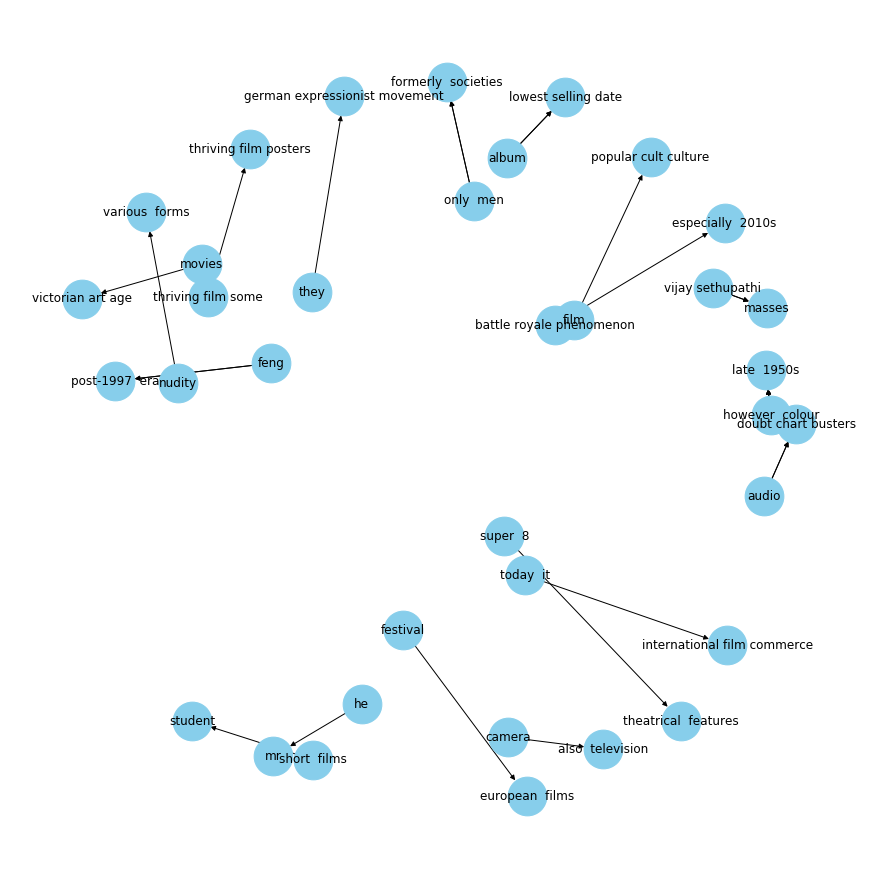

In [60]:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="become"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()
